In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

### Data load

In [2]:
X_train1 = np.load('../ReactionClassification_2024/data/OptBertFPFinal2/X_train1_OptBertFP.npy',allow_pickle=True)
X_train2 = np.load('../ReactionClassification_2024/data/OptBertFPFinal2/X_train2_OptBertFP.npy',allow_pickle=True)
X_train3 = np.load('../ReactionClassification_2024/data/OptBertFPFinal2/X_train3_OptBertFP.npy',allow_pickle=True)
X_train4 = np.load('../ReactionClassification_2024/data/OptBertFPFinal2/X_train4_OptBertFP.npy',allow_pickle=True)
X_train5 = np.load('../ReactionClassification_2024/data/OptBertFPFinal2/X_train5_OptBertFP.npy',allow_pickle=True)
X_train6 = np.load('../ReactionClassification_2024/data/OptBertFPFinal2/X_train6_OptBertFP.npy',allow_pickle=True)
X_train7 = np.load('../ReactionClassification_2024/data/OptBertFPFinal2/X_train7_OptBertFP.npy',allow_pickle=True)
X_train8 = np.load('../ReactionClassification_2024/data/OptBertFPFinal2/X_train8_OptBertFP.npy',allow_pickle=True)
X_train9 = np.load('../ReactionClassification_2024/data/OptBertFPFinal2/X_train9_OptBertFP.npy',allow_pickle=True)
X_train10 = np.load('../ReactionClassification_2024/data/OptBertFPFinal2/X_train10_OptBertFP.npy',allow_pickle=True)
X_test = np.load('data/OptBertFPFinal2/X_test_OptBertFP.npy',allow_pickle=True)
X_val = np.load('data/OptBertFPFinal2/X_val_OptBertFP.npy',allow_pickle=True)

In [3]:
train = pd.read_csv('data/train.csv', delimiter=',')
test = pd.read_csv('data/test.csv', delimiter=',')
val = pd.read_csv('data/val.csv', delimiter=',')

In [4]:
y_train = train['CLASS-ID'].values
y_test = test['CLASS-ID'].values
y_val = val['CLASS-ID'].values

In [5]:
X_train = np.concatenate([X_train1, X_train2, X_train3, X_train4, X_train5,
                          X_train6, X_train7, X_train8, X_train9, X_train10], axis=0)
X_train1 = np.vstack(X_train)

In [6]:
X_train = np.squeeze(X_train1)
X_test = np.squeeze(X_test)
X_val = np.squeeze(X_val)

In [7]:
df_test1nn = pd.read_csv('data/OptBertFPFinal2/df_test1nn.csv', delimiter=',')

In [8]:
y_pred_test_1nn = np.load('data/OptBertFPFinal2/y_pred_test_1nn.npy')

### Evaluation

In [9]:
df_class = pd.read_csv('data/className.tsv', sep='\t', encoding='ISO-8859-1')

In [10]:
# Convert multi Class-ID into one
def clean_class_id(row):
    # Split the string by comma and convert to a list
    class_ids = str(row['CLASS-ID']).split(',')
    # Return the first element from the list, ensuring it's an integer
    return int(class_ids[0].strip())

# Apply the function to the 'CLASS-ID' column
df_class['CLASS-ID'] = df_class.apply(clean_class_id, axis=1)
df_class['CLASS-ID'] = df_class['CLASS-ID'].astype(int)

In [11]:
df_test1nn

,CLASS-ID,precision,recall,f1-score,test_support,train_support,TRANSFORM_NAME,TRANSFORM_ID
0,1085,0.999119,0.999439,0.999279,24966,185024,"Suzuki coupling, Suzuki-Miyaura Cross-Coupling","(ARCOUPLG)4.1.B, (AVNAMEDR)Suzuki-Miyaura"
1,432,0.985543,0.987629,0.986585,21259,164914,N-alkylation of alkylamines,(AG2ALKN)1.1.2
2,1016,0.994318,0.993100,0.993709,15507,113635,hydrolysis of carboxylic esters,(AQCLEAV1)1.1
3,60,0.999374,0.999464,0.999419,11185,85921,reduction of C-NO2 to C-NH2,(AAREDUCT)A.1
4,433,0.956146,0.956625,0.956386,7977,60554,"N-alkylation of benzenoid amines, anilines",(AG2ALKN)1.1.3
...,...,...,...,...,...,...,...,...
1294,1267,1.000000,1.000000,1.000000,1,8,Brackeen Imidazole Synthesis,(AVNAMEDR)Brackeen
1295,1800,1.000000,1.000000,1.000000,5,8,Shestakov Hydrazino Acid Synthesis,(AVNAMEDR)Shestakov
1296,500,0.000000,0.000000,0.000000,1,7,"O-propargylation of N-hydroxy amides, includin...",(AG2ALKO)2.4.1
1297,1622,1.000000,1.000000,1.000000,1,7,ListMacMillan Hydrogenation,(AVNAMEDR)List-MacMillan


In [12]:
df_test1nn['SUPER_TRANSFORM_ID'] = df_test1nn['TRANSFORM_ID'].str.extract(r'\((.*?)\)')

In [13]:
def weighted_mean(values, weights):
    return (values * weights).sum() / weights.sum()

In [14]:
grouped = df_test1nn.groupby('SUPER_TRANSFORM_ID')

grouped_metrics = grouped.apply(lambda x: pd.Series({
    'weighted_precision': weighted_mean(x['precision'], x['test_support']),
    'weighted_recall': weighted_mean(x['recall'], x['test_support']),
    'weighted_f1-score': weighted_mean(x['f1-score'], x['test_support']),
    'total_test_support': x['test_support'].sum(),
    'total_train_support': x['train_support'].sum(),
    'class_count': len(x)
}))

In [15]:
grouped_metrics.sort_values(by=['SUPER_TRANSFORM_ID'])

,weighted_precision,weighted_recall,weighted_f1-score,total_test_support,total_train_support,class_count
SUPER_TRANSFORM_ID,,,,,,
AAREDUCT,0.980907,0.979424,0.980101,36644.0,250984.0,53.0
ABOXIDAT,0.897971,0.899569,0.898458,24813.0,175151.0,105.0
ACADD,0.971703,0.976918,0.974235,15640.0,114981.0,37.0
ADELIMIN,0.981364,0.978967,0.980110,10650.0,67085.0,21.0
AEREARR,0.959260,0.960981,0.959308,2486.0,17393.0,36.0
AFCYCLIZ,0.957406,0.945107,0.950955,4026.0,31313.0,30.0
AG1ARYL,0.954370,0.963109,0.958606,7373.0,55032.0,20.0
AG2ALKC,0.894514,0.899479,0.895408,3840.0,26254.0,58.0
AG2ALKN,0.975265,0.974710,0.974928,35864.0,270086.0,16.0


In [16]:
# Calculate macro average for precision, recall, and f1-score
macro_precision2 = df_test1nn['precision'].mean()
macro_recall2 = df_test1nn['recall'].mean()
macro_f12 = df_test1nn['f1-score'].mean()

# Calculate weighted average for precision, recall, and f1-score
weighted_precision2 = (df_test1nn['precision'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()
weighted_recall2 = (df_test1nn['recall'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()
weighted_f12 = (df_test1nn['f1-score'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()

In [17]:
output1 = f"""
Macro-averages:
- Precision: {macro_precision2:.4f}
- Recall: {macro_recall2:.4f}
- F1-score: {macro_f12:.4f}

Weighted-averages:
- Precision: {weighted_precision2:.4f}
- Recall: {weighted_recall2:.4f}
- F1-score: {weighted_f12:.4f}
"""

In [18]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_test_1nn)}')

Accuracy: 0.961808893322451


In [19]:
print(output1)


Macro-averages:
- Precision: 0.8889
- Recall: 0.8761
- F1-score: 0.8759

Weighted-averages:
- Precision: 0.9619
- Recall: 0.9618
- F1-score: 0.9616



In [20]:
summary_stats = df_test1nn[["precision", "recall", "f1-score", "test_support", "train_support"]].describe()
summary_stats

,precision,recall,f1-score,test_support,train_support
count,1299.000000,1299.000000,1299.000000,1299.000000,1299.000000
mean,0.888880,0.876080,0.875932,254.665127,1851.890685
std,0.184327,0.196985,0.185293,1212.528218,9034.637418
min,0.000000,0.000000,0.000000,1.000000,7.000000
25%,0.857143,0.837374,0.845299,6.000000,39.000000
50%,0.960000,0.960000,0.945626,24.000000,160.000000
75%,1.000000,1.000000,0.988905,110.500000,811.000000
max,1.000000,1.000000,1.000000,24966.000000,185024.000000


In [21]:
low_f1_reactions = df_test1nn[df_test1nn['f1-score'] < df_test1nn['f1-score'].quantile(0.25)].head(10)

### Wrong predict evaluation in details

In [86]:
class_to_transform_id = pd.Series(df_class['TRANSFORM_NAME'].values,index=df_class['CLASS-ID']).to_dict()

In [87]:
y_pred_flattened = y_pred_test_1nn.flatten() 

In [88]:
mismatches = y_pred_flattened != y_test

full_comparison_df = pd.DataFrame({
    'CLASS-ID': y_test,
    'CLASS-ID-predict': y_pred_flattened,
    'Misclassified': mismatches
})

misclassified_df = full_comparison_df[full_comparison_df['Misclassified'] == True].sort_values(by=['CLASS-ID', 'CLASS-ID-predict'])

In [89]:
counts = misclassified_df.groupby(['CLASS-ID', 'CLASS-ID-predict']).size().reset_index(name='Count')
top_counts = (counts.sort_values(by=['CLASS-ID', 'Count'], ascending=[True, False])
             .groupby('CLASS-ID')
             .head(3))

In [90]:
reshaped_df = pd.DataFrame()
rows = []
for i, group in top_counts.groupby('CLASS-ID'):
    reshaped_row = {'CLASS-ID': i}
    for j, (index, row) in enumerate(group.iterrows(), start=1):
        reshaped_row[f'Top{j}_CLASS-ID-predict'] = row['CLASS-ID-predict']
        reshaped_row[f'Top{j}_Count'] = row['Count']
    rows.append(reshaped_row)

# Use concat instead of append
reshaped_df = pd.concat([reshaped_df, pd.DataFrame(rows)], ignore_index=True)

# Process columns as needed
reshaped_df = reshaped_df[['CLASS-ID'] + [col for col in reshaped_df.columns if col != 'CLASS-ID']].fillna(0).astype(int)

In [91]:
reshaped_df['Top1_MISTRANSFORM_NAME'] = reshaped_df['Top1_CLASS-ID-predict'].map(class_to_transform_id)
reshaped_df['Top2_MISTRANSFORM_NAME'] = reshaped_df['Top2_CLASS-ID-predict'].map(class_to_transform_id)
reshaped_df['Top3_MISTRANSFORM_NAME'] = reshaped_df['Top3_CLASS-ID-predict'].map(class_to_transform_id)

In [92]:
df_low = pd.merge(low_f1_reactions, reshaped_df[['CLASS-ID', 'Top1_MISTRANSFORM_NAME', 'Top1_Count', 'Top2_MISTRANSFORM_NAME', 'Top2_Count', 'Top3_MISTRANSFORM_NAME', 'Top3_Count']], on='CLASS-ID', how='left')

In [93]:
df_low

,CLASS-ID,precision,recall,f1-score,test_support,train_support,TRANSFORM_NAME,TRANSFORM_ID,SUPER_TRANSFORM_ID,Top1_MISTRANSFORM_NAME,Top1_Count,Top2_MISTRANSFORM_NAME,Top2_Count,Top3_MISTRANSFORM_NAME,Top3_Count
0,109,0.808664,0.816525,0.812576,1646,12611,"Dess-Martin ketone synthesis, Dess-Martin oxid...","(ABOXIDAT)5.2.3, (AVNAMEDR)Dess-Martin1.2",ABOXIDAT,Corey-Suggs Reagent,174,"Swern oxidation of alcohols to ketones, Swern ...",105,"Jones ketone synthesis, Jones oxidation of alc...",12
1,1331,0.708185,0.716257,0.712198,1667,12096,Corey-Suggs Reagent,(AVNAMEDR)Corey-Suggs,AVNAMEDR,"Dess-Martin ketone synthesis, Dess-Martin oxid...",165,"Dess-Martin aldehyde synthesis, Dess-Martin ox...",118,"Swern aldehyde synthesis, Swern oxidation of a...",95
2,99,0.753434,0.759170,0.756291,1445,10979,"Dess-Martin aldehyde synthesis, Dess-Martin ox...","(ABOXIDAT)5.1.3, (AVNAMEDR)Dess-Martin1.1",ABOXIDAT,"Swern aldehyde synthesis, Swern oxidation of a...",192,Corey-Suggs Reagent,119,"Parikh-Doering aldehyde synthesis, Parikh-Doer...",18
3,864,0.848819,0.819149,0.833720,1316,10486,condensation of heteroaryl aldehydes with hydr...,(AHCONDEN)7.1.3,AHCONDEN,condensation of aromatic aldehydes with hydraz...,227,condensation of aliphatic aldehydes with hydra...,10,condensation of heteroaryl aldehydes with hydr...,1
4,97,0.676798,0.683027,0.679898,978,7239,"Swern aldehyde synthesis, Swern oxidation of a...","(ABOXIDAT)5.1.1, (AVNAMEDR)Swern1.1",ABOXIDAT,"Dess-Martin aldehyde synthesis, Dess-Martin ox...",200,Corey-Suggs Reagent,90,"Parikh-Doering aldehyde synthesis, Parikh-Doer...",12
5,868,0.784071,0.792487,0.788256,559,4429,condensation of heteroaryl alkyl ketones with ...,(AHCONDEN)7.2.4,AHCONDEN,condensation of phenyl alkyl ketones with hydr...,78,condensation of dialkyl ketones with hydrazines,30,condensation of heteroaryl phenyl ketones with...,5
6,79,0.828753,0.830508,0.829630,472,3686,"osmylation of alkenes to 1,2-diols",(ABOXIDAT)2.1.1,ABOXIDAT,"permanganate oxidation of alkenes to 1,2-diols",35,"oxidation of alkenes to 1,2-diols with peroxoi...",34,"ruthenium-catalyzed oxidation of alkenes to 1,...",5
7,107,0.565217,0.562642,0.563927,439,3377,"Swern oxidation of alcohols to ketones, Swern ...","(ABOXIDAT)5.2.1, (AVNAMEDR)Swern1.2",ABOXIDAT,"Dess-Martin ketone synthesis, Dess-Martin oxid...",123,Corey-Suggs Reagent,58,"Jones ketone synthesis, Jones oxidation of alc...",4
8,772,0.773333,0.760656,0.766942,305,2370,O-silylation of tertiary alkanols,(AG7SILYL)3.1.3,AG7SILYL,O-silylation of secondary alkanols,62,O-silylation of primary alkanols,6,O-silylation of phenols,4
9,186,0.818182,0.804878,0.811475,246,1887,oxidation of heteroaryl aryl sulfides to sulfones,(ABOXIDAT)K.2.5,ABOXIDAT,oxidation of diaryl sulfides to sulfones,29,oxidation of alkyl aryl sulfides to sulfones,18,oxidation of sulfoxides to sulfones,1


In [97]:
df_low['TRANSFORM_NAME'][3]

'condensation of heteroaryl aldehydes with hydrazines'

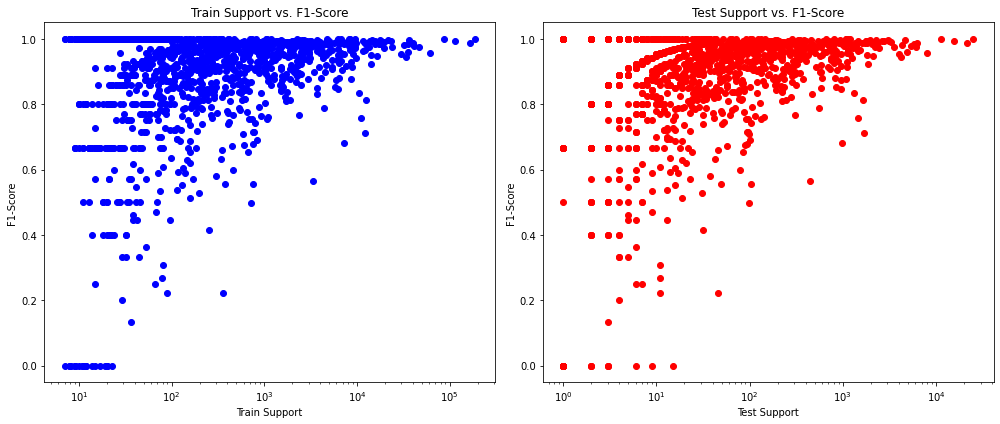

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(df_test1nn['train_support'], df_test1nn['f1-score'], color='blue')
ax1.set_title('Train Support vs. F1-Score')
ax1.set_xlabel('Train Support')
ax1.set_ylabel('F1-Score')
ax1.set_xscale('log')  # Set x-axis to log scale

ax2.scatter(df_test1nn['test_support'], df_test1nn['f1-score'], color='red')
ax2.set_title('Test Support vs. F1-Score')
ax2.set_xlabel('Test Support')
ax2.set_ylabel('F1-Score')
ax2.set_xscale('log')  # Set x-axis to log scale

plt.tight_layout()
plt.show()

### TMAP

In [25]:
X_test.shape

(330810,)

In [28]:
import numpy as np

# Assuming X_test is your full dataset loaded as a NumPy array
np.random.seed(42)
indices = np.random.choice(X_test.shape[0], size=10000, replace=False)
X_sample = X_test[indices]